In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score, precision_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

import os
os.chdir('../assets')
import reddit as reddit
os.chdir('.')

In [2]:
df = pd.read_csv('../data/joined_wallstreetbets_investing.csv')

In [3]:
X = df['combined']
y = df['sub_target']

X_train, X_validation, y_train, y_validation = train_test_split(X, y, random_state=42)

# Print baseline accuracy
print(f'Baseline accuracy:\n{y_validation.value_counts(normalize=True)}')

Baseline accuracy:
1    0.504129
0    0.495871
Name: sub_target, dtype: float64


In [4]:
add_stopwords = ['amp', 'amp x200b', 'fintel', 'io', 'https', 'www', 'http', 'com', 'wallstreetbets', 'reddit', 'restrict_sr']

In [5]:
# params = reddit.get_params()

In [6]:
# gs = reddit.run_model(params, X_train, y_train, add_stopwords)

In [7]:
# preds = gs.predict(X_validation)

In [8]:
# tn, fp, fn, tp = confusion_matrix(y_validation, preds).ravel()

In [9]:
# gs.score(X_validation, y_validation)

In [10]:
# tn / (tn+fp)

In [11]:
# recall_score(y_validation, preds)

In [12]:
# precision_score(y_validation, preds)

In [13]:
# f1_score(y_validation, preds)

In [14]:
# plot_confusion_matrix(gs, X_validation, y_validation, cmap='Blues', 
#                       values_format='d', display_labels=['investing', 'wallstreetbets']);   # Need to update alive/dead to correct subreddits

In [15]:
# Consider prompting if the user wants to pickle/save the model; if so, prompt for filename.

# Sentiment Analysis

In [16]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [215]:
positive_words = ['black', 'green', 'buy', 'bull', 'bullish', 'long', 'surplus', 'positive', 
                  'up', 'increase', 'skyrocket', 'rise', 'gain', 'gains', 'gained', 'profit', 
                  'calls', 'positive', 'happy', 'significant', 'boost', 'undervalued', 'explosive',
                  'outperform', 'jump', 'cheap', 'uptrend', 'strong', 'enter', 'higher', 'accumulate',
                  'hopeful', 'addition', 'approval', 'solid', 'upside', 'accelerate', 'better',
                  'good', 'burst', 'climb', 'over', 'breakout', 'maintain', 'opportunity', 'make', 
                  'best', 'like']

negative_words = ['red', 'sell', 'bear', 'bearish', 'short', 'shorting', 'debt', 'negative', 
                  'down', 'decrease', 'plummet', 'drop', 'lose', 'loss', 'lost', 'puts', 
                  'negative', 'risk', 'uncertain', 'worse', 'alleged', 'insignificant', 
                  'dip', 'downside', 'overvalued', 'caution', 'cautious', 'sink', 'downtrend',
                  'weak', 'dump', 'trap', 'exit', 'lower', 'divest', 'dismal', 'below', 'low',
                  'reduce', 'reduction', 'abandon', 'blood', 'bloodbath', 'bogus', 'bad', 'chump',
                  'corrupt', 'costly', 'crash', 'damage', 'danger', 'depression', 'avoid', 'under',
                  'worst', 'hate']

In [216]:
p_stemmer = PorterStemmer()

In [217]:
positive_stems = list(set([p_stemmer.stem(word) for word in positive_words]))

In [218]:
negative_stems = list(set([p_stemmer.stem(word) for word in negative_words]))

In [219]:
tokenizer = RegexpTokenizer(r'\w+')

# https://stackoverflow.com/questions/57039945/use-regexptokenizer-in-a-pandas-dataframe
df['tokens'] = df['combined'].map(tokenizer.tokenize)

In [220]:
# Code help from James Hampton

def list_stem(token_list, stemmer=p_stemmer):
    return [stemmer.stem(x) for x in token_list]

In [221]:
df['stemmed'] = df['tokens'].map(list_stem)

In [222]:
def stock_sent(stemmed):
    positive_count = sum([1 for word in stemmed if word in positive_stems])
    negative_count = sum([1 for word in stemmed if word in negative_stems])
    return (positive_count - negative_count) / len(stemmed)

In [223]:
df['stock_sentiment'] = df['stemmed'].map(stock_sent)

In [26]:
sentiment = SentimentIntensityAnalyzer()

In [27]:
# sentiment.polarity_scores(df['combined'][2])

In [28]:
# https://medium.com/swlh/simple-sentiment-analysis-for-nlp-beginners-and-everyone-else-using-vader-and-textblob-728da3dbe33d
df['compound_sent'] = [sentiment.polarity_scores(v)['compound'] for v in df['combined']]

In [224]:
df['stock_sentiment_sign'] = np.where(df['stock_sentiment'] > 0, 'Positive', (np.where(df['stock_sentiment'] < 0, 'Negative', 'Neutral')))
df['compound_sent_sign'] = np.where(df['compound_sent'] > 0, 'Positive', (np.where(df['compound_sent'] < 0, 'Negative', 'Neutral')))

In [225]:
neutrals = df[df['stock_sentiment_sign']=='Neutral']

In [229]:
neutrals.head()

,Unnamed: 0,index,title,selftext,author,subreddit,sub_target,combined,char_count,word_count,tokens,stemmed,stock_sentiment,compound_sent,stock_sentiment_sign,compound_sent_sign
8,8,8,Gamestop Partners with Sony For a % Commission...,...... maybe one day.\n\n\njust imagine if thi...,SourceCodeSeller,wallstreetbets,1,gamestop partners with sony for a % commission...,468,70,"[gamestop, partners, with, sony, for, a, commi...","[gamestop, partner, with, soni, for, a, commis...",0.0,0.3612,Neutral,Positive
16,16,16,AMD,I really think this is a hell of a investment ...,kinggoku123,wallstreetbets,1,amd i really think this is a hell of a investm...,307,65,"[amd, i, really, think, this, is, a, hell, of,...","[amd, i, realli, think, thi, is, a, hell, of, ...",0.0,0.6731,Neutral,Positive
36,36,36,Never made money on TSLA,"Back in the pre-split days, I always caught TS...",firstonesnotfree,wallstreetbets,1,never made money on tsla back in the pre-split...,567,102,"[never, made, money, on, tsla, back, in, the, ...","[never, made, money, on, tsla, back, in, the, ...",0.0,-0.1838,Neutral,Negative
40,40,40,A coin of our own for r/wsb,Why is r/cryptocurrency the only one with thei...,philhh,wallstreetbets,1,a coin of our own for r/wsb why is r/cryptocur...,251,49,"[a, coin, of, our, own, for, r, wsb, why, is, ...","[a, coin, of, our, own, for, r, wsb, whi, is, ...",0.0,0.8070,Neutral,Positive
53,53,53,Gilead - Can't go wrong,Why you ask? Cuz Donney won't let it crash. He...,Sad-hurt-and-depress,wallstreetbets,1,gilead - can't go wrong why you ask? cuz donne...,332,64,"[gilead, can, t, go, wrong, why, you, ask, cuz...","[gilead, can, t, go, wrong, whi, you, ask, cuz...",0.0,0.5875,Neutral,Positive


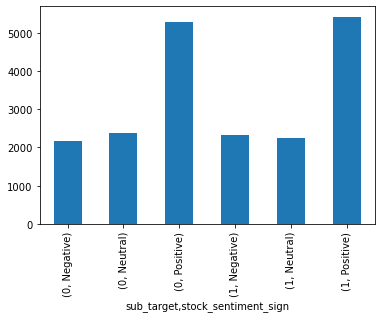

In [151]:
df.groupby(['sub_target', 'stock_sentiment_sign'])['index'].count().plot(kind='bar');

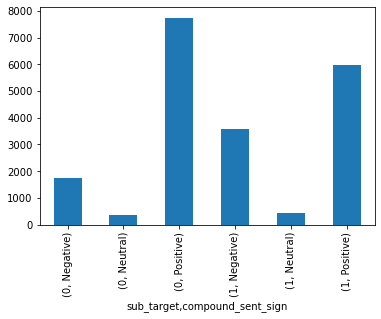

In [94]:
df.groupby(['sub_target', 'compound_sent_sign'])['index'].count().plot(kind='bar')

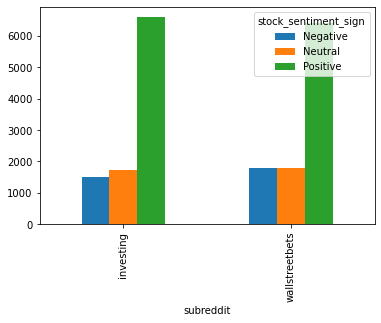

In [227]:
df.groupby(['subreddit', 'stock_sentiment_sign']).count()['index'].unstack().plot.bar();

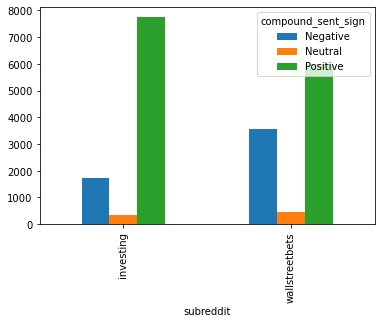

In [172]:
df.groupby(['subreddit', 'compound_sent_sign']).count()['index'].unstack().plot.bar();

In [230]:
df['stock_sentiment_sign'].value_counts()

Positive    13027
Neutral      3512
Negative     3319
Name: stock_sentiment_sign, dtype: int64

In [231]:
t_positive = 0
f_positive = 0
t_neutral = 0
f_neutral = 0
t_negative = 0
f_negative = 0

for i in range(len(df)):
    if df['stock_sentiment_sign'][i] == 'Positive' and df['compound_sent_sign'][i] == 'Positive':
        t_positive += 1
    elif df['stock_sentiment_sign'][i] == 'Positive' and df['compound_sent_sign'][i] != 'Positive':
        f_positive += 1
    elif df['stock_sentiment_sign'][i] == 'Neutral' and df['compound_sent_sign'][i] == 'Neutral':
        t_neutral += 1
    elif df['stock_sentiment_sign'][i] == 'Neutral' and df['compound_sent_sign'][i] != 'Neutral':
        f_neutral += 1
    elif df['stock_sentiment_sign'][i] == 'Negative' and df['compound_sent_sign'][i] == 'Negative':
        t_negative += 1
    elif df['stock_sentiment_sign'][i] == 'Negative' and df['compound_sent_sign'][i] != 'Negative':
        f_negative += 1
        
print(f'Accuracy of predictions: {((t_positive+t_neutral+t_negative)/(t_positive+f_positive+t_neutral+f_neutral+t_negative+f_negative))}')

Accuracy of predictions: 0.6025279484338806


In [240]:
t_positive/13742

0.7298064328336487

In [241]:
t_neutral/811

0.5215782983970407

In [242]:
t_negative/5305

0.28520263901979265

In [239]:
df['compound_sent_sign'].value_counts()

Positive    13742
Negative     5305
Neutral       811
Name: compound_sent_sign, dtype: int64

In [232]:
df['compound_sent_sign'].value_counts(normalize=True)

Positive    0.692013
Negative    0.267147
Neutral     0.040840
Name: compound_sent_sign, dtype: float64